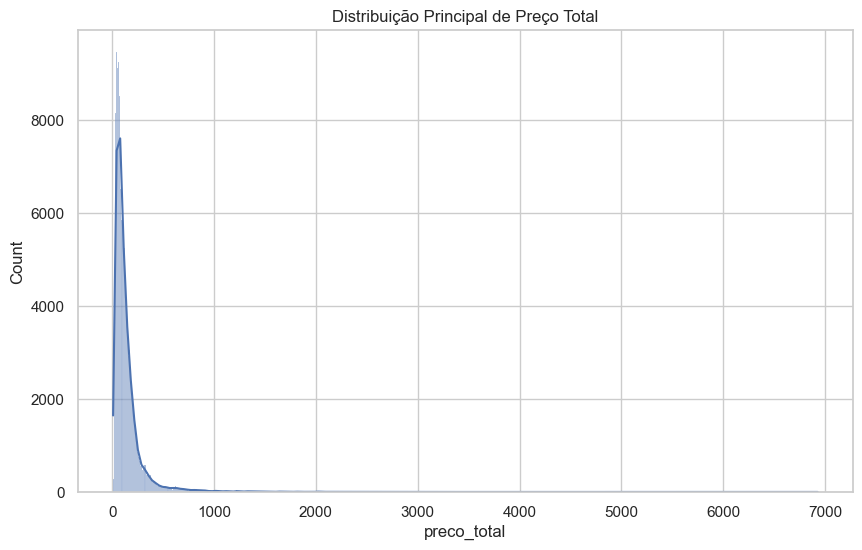

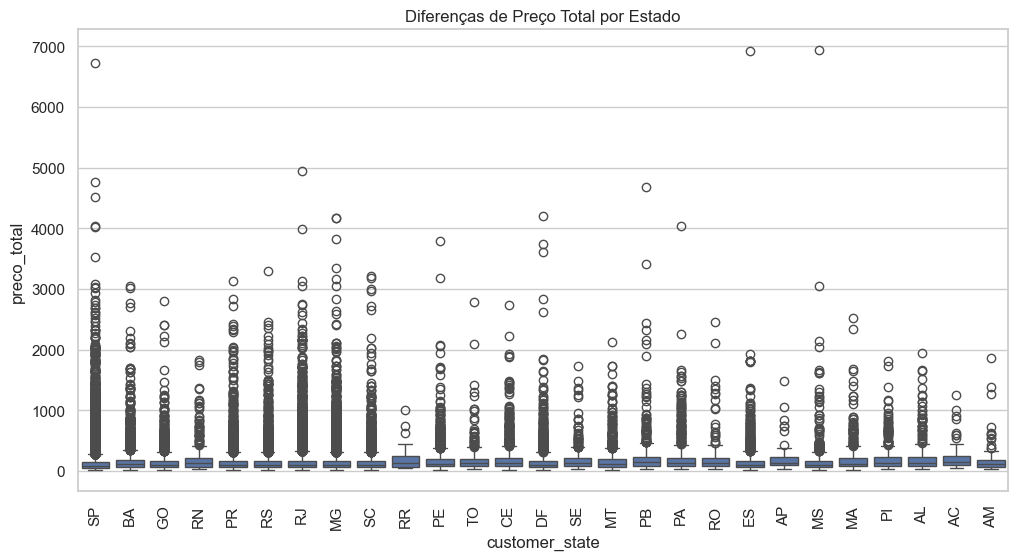

ANOVA: F=45.56797279660397, p-value=4.103627761329368e-232


C:\Users\jose.pedro\AppData\Local\Temp\ipykernel_59812\2237070982.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = dados.set_index('order_purchase_timestamp')['preco_total'].resample('M').sum()


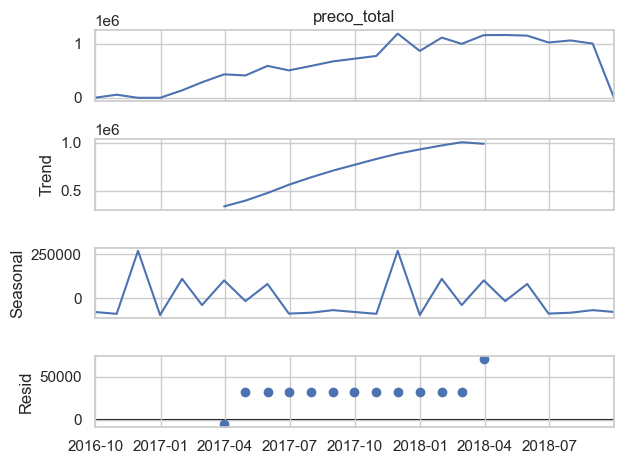

In [ ]:
# Célula 1: Importações e Carga de Dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import plotly.express as px
from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

dados = pd.read_csv('dados_integrados_preprocessados.csv')
dados['order_purchase_timestamp'] = pd.to_datetime(dados['order_purchase_timestamp'])
sns.set(style='whitegrid')

# 1. Distribuição principal (histograma + KDE) de preco_total
plt.figure(figsize=(10,6))
sns.histplot(dados['preco_total'], kde=True)
plt.title('Distribuição Principal de Preço Total')
plt.show()

# 2. Diferenças entre grupos (boxplots + testes) - por customer_state
plt.figure(figsize=(12,6))
sns.boxplot(data=dados, x='customer_state', y='preco_total')
plt.title('Diferenças de Preço Total por Estado')
plt.xticks(rotation=90)
plt.show()
# Teste ANOVA (exemplo para múltiplos grupos)
groups = [dados[dados['customer_state'] == state]['preco_total'] for state in dados['customer_state'].unique()]
f_stat, p_val = stats.f_oneway(*groups)
print(f'ANOVA: F={f_stat}, p-value={p_val}')

# 3. Métrica ao longo do tempo (tendência, sazonalidade, decomposição)
ts = dados.set_index('order_purchase_timestamp')['preco_total'].resample('ME').sum()
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
decomposition.plot()
plt.show()

# 4. Relação não-linear entre preco_total e review_score (scatter + lowess)
plt.figure(figsize=(10,6))
sns.regplot(x='preco_total', y='review_score', data=dados, lowess=True)
plt.title('Relação Não-Linear: Preço Total vs Review Score')
plt.show()

# 5. Clusters naturais (PCA + scatter colorido por cluster)
pca = PCA(n_components=2)
reduced = pca.fit_transform(dados[['preco_total', 'review_score', 'freight_value']].fillna(0))
kmeans = KMeans(n_clusters=3)
dados['cluster'] = kmeans.fit_predict(reduced)
px.scatter(dados, x=reduced[:,0], y=reduced[:,1], color='cluster').show()

# 6. Outliers multivariados (Mahalanobis + boxplots)
from scipy.spatial.distance import mahalanobis
cov = dados[['preco_total', 'review_score']].cov().values
mean = dados[['preco_total', 'review_score']].mean().values
dados['mahalanobis'] = dados.apply(lambda row: mahalanobis([row['preco_total'], row['review_score']], mean, cov), axis=1)
outliers = dados[dados['mahalanobis'] > 3]
sns.boxplot(data=dados, y='preco_total')
plt.scatter(outliers.index, outliers['preco_total'], color='red')
plt.title('Outliers em Preço Total')
plt.show()

# 7. Correlação entre variáveis (heatmap com clustering)
corr = dados[['preco_total', 'review_score', 'freight_value', 'price']].corr()
sns.clustermap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação')
plt.show()

# 8. Heterocedasticidade (violin plots + testes) - variância por order_status
sns.violinplot(data=dados, x='order_status', y='preco_total')
plt.title('Heterocedasticidade por Status de Ordem')
plt.show()
# Teste Levene
groups = [dados[dados['order_status'] == status]['preco_total'] for status in dados['order_status'].unique()]
stat, p = stats.levene(*groups)
print(f'Teste Levene: {stat}, p-value={p}')

# 9. Segmentos com melhor custo-benefício (bubble chart) - preco_total vs review_score ponderada
dados['custo_beneficio'] = dados['review_score'] / dados['preco_total']
px.scatter(dados, x='preco_total', y='review_score', size='custo_beneficio', color='customer_state', hover_name='order_id').show()

# 10. Elasticidade (regressões locais) - preco_total vs volume (contagem de itens por ordem, placeholder)
# Agregar volume por ordem
volume = dados.groupby('order_id')['order_item_id'].count().reset_index(name='volume')
dados = dados.merge(volume, on='order_id')
px.scatter(dados, x='preco_total', y='volume', trendline='lowess').show()

# 11. Distribuição condicional por subgrupos (faceted plots) - por customer_state
g = sns.FacetGrid(dados, col='customer_state', col_wrap=5)
g.map(sns.histplot, 'preco_total', kde=True)
plt.show()

# 12. Features mais importantes (permutation importance) - para variações em preco_total
X = dados[['review_score', 'freight_value', 'price']]  # Features
y = dados['preco_total']
rf = RandomForestRegressor()
rf.fit(X, y)
perm = permutation_importance(rf, X, y)
px.bar(x=X.columns, y=perm.importances_mean, title='Feature Importance').show()

# 13. Padrões geoespaciais (choropleth) - agregação de preco_total por customer_state
state_sales = dados.groupby('customer_state')['preco_total'].sum().reset_index()
fig = px.choropleth(state_sales, locations='customer_state', locationmode='BRA-states', color='preco_total',
                    scope='south america', title='Vendas por Estado (Brasil)')
fig.show()

# 14. Histórico de reviews e tópicos (topic modelling + wordcloud)
# Topic modelling simples com LDA
dados_text = dados.dropna(subset=['review_comment_message'])
vectorizer = CountVectorizer(stop_words='english')
X_text = vectorizer.fit_transform(dados_text['review_comment_message'])
lda = LatentDirichletAllocation(n_components=5)
lda.fit(X_text)
# Wordcloud por tópico (exemplo para tópico 0)
terms = vectorizer.get_feature_names_out()
topic_words = [terms[i] for i in lda.components_[0].argsort()[-10:]]
text = ' '.join(topic_words)
wc = WordCloud().generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud de Tópico Dominante em Reviews')
plt.show()

# 15. Agregação temporal (comparação de plots) - diária, semanal, mensal
dados['data_diaria'] = dados['order_purchase_timestamp'].dt.date
diaria = dados.groupby('data_diaria')['preco_total'].sum()
semanal = dados.resample('W', on='order_purchase_timestamp')['preco_total'].sum()
mensal = dados.resample('ME', on='order_purchase_timestamp')['preco_total'].sum()
plt.figure(figsize=(12,6))
diaria.plot(label='Diária')
semanal.plot(label='Semanal')
mensal.plot(label='Mensal')
plt.title('Comparação de Agregações Temporais de Preço Total')
plt.legend()
plt.show()